<a href="https://colab.research.google.com/github/lsaif/Non-Conventional-Field-Assesment/blob/main/Scoring_and_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

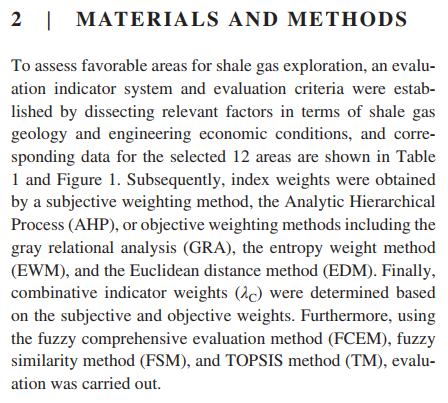

###**Requirements**

In [1]:
#Requirements
import sys
import numpy as np
import pandas as pd
sys.path.append('/content/drive/MyDrive/SKK-MNK/')
!pip install ahpy
import ahpy

#### Whitenization
def type1(x, x1, x2, x3, x4, a, b):
  if x < x1:
    score = 0
  elif x < x2:
    score = np.exp(-a*((x-b)**2)/2) #np.sin(a*x+b)
  elif x < x3:
    score = 1
  elif x < x4:
    score = np.exp(-a*((x-b)**2)/2)
  else:
    score = 0

  return score

def type2(x, x3, x4, a):
  b = x3
  if x < x3:
    score = 1
  elif x < x4:
    score = np.exp(-a*((x-b)**2)/2)
  else:
    score = 0

  return score

def type3(x, x1, x2, x4, a, b):
  if x < x1:
    score = 0
  elif x < x2:
    score = np.sin(a*x+b)
  elif x < x4:
    score = np.exp(-a*((x-b)**2)/2)
  else:
    score = 0

  return score

def type4(x, x1, x2, b):
  a = 1
  c = x1
  if x < x1:
    score = 0
  else:
    score = a*b*(x-c)/(1+b*(x-c))
  # elif x < x2:
  #   score = a*b*(x-c)/(1+b*(x-c))
  # else:
  #   score = 1

  return score

###**Input File**

In [2]:
# data = pd.read_csv('/content/drive/MyDrive/SKK-MNK/data/SourceRock_pass.csv', sep=';')
data = pd.read_csv('/content/drive/MyDrive/SKK-MNK/data/WKRank_14122021.csv', sep=';')

# Source Rock
data = data[data['TOC'].notna()]
data = data[data['HI'].notna()]
data = data[data['BI'].notna()]
data = data[data['Sandshale'].notna()]

# Overall
data = data[data['Thickness'].notna()]
data = data[data['Area'].notna()]
data = data[data['HutanLindung'].notna()]
data = data[data['EUR'].notna()]
data = data[data['Field'].notna()]
# data = data[data['BASIN'].str.contains("Sumatra")]
# data

###**Scoring**

In [3]:
#### Subsurface
## Source rock quality
# depth = [type2(x, 0, 10000, 0.0003) for x in data.Depth]
# Ro = [type3(x, 0.6, 1.2, 1.3, 2, 1) for x in data.Ro]
# Ro = [type1(x, 0.6, 1.2, 1.2, 2, 1, 2) for x in data.Ro]
toc = [type4(x, 0, 10, 3) for x in data.TOC]                      # TOC value
HI = [type4(x, 150, 300, 0.01) for x in data.HI]                  # HI value
sandshale = [type4(x, 0.2, 1, 0.9) for x in data.Sandshale]       # Sand to shale ratio
BI = [type4(x, 0.4, 1, 10) for x in data.BI]                      # Brittleness Index
thickness = [type4(x, 20, 10000, 0.1) for x in data.Thickness]    # Source rock thickness
Area = [type4(x, 0, 1000000000, 0.000000009) for x in data.Area]  # Area

#### Surface
# distance_to_facility = [type2(x, 0, 100, 3) for x in data.distance_to_facility]             # Distance to closest facility
# distance_to_waterresouce = [type2(x, 0, 100, 3) for x in data.distance_to_waterresource]    # Distance to water sources
# accessibility = [type2(x, 0, 100, 3) for x in data.accessibility]                           # Accessibility
hutan =  [type2(x, 0, 100, 0.01) for x in data.HutanLindung]                                # Landuse area
EUR = [type4(x, 0, 10000, 0.0009) for x in data.EUR]                                        # EUR
field = [type4(x, 0, 1000, 0.009) for x in data.Field]                                      # Field area

###**Topsis**

In [4]:
import warnings

class Topsis():
    evaluation_matrix = np.array([])  # Matrix
    weighted_normalized = np.array([])  # Weight matrix
    normalized_decision = np.array([])  # Normalisation matrix
    M = 0  # Number of rows
    N = 0  # Number of columns

    '''
	Create an evaluation matrix consisting of m alternatives and n criteria,
	with the intersection of each alternative and criteria given as {\displaystyle x_{ij}}x_{ij},
	we therefore have a matrix {\displaystyle (x_{ij})_{m\times n}}(x_{{ij}})_{{m\times n}}.
	'''

    def __init__(self, evaluation_matrix, weight_matrix, criteria):
        # M×N matrix
        self.evaluation_matrix = np.array(evaluation_matrix, dtype="float")

        # M alternatives (options)
        self.row_size = len(self.evaluation_matrix)

        # N attributes/criteria
        self.column_size = len(self.evaluation_matrix[0])

        # N size weight matrix
        self.weight_matrix = np.array(weight_matrix, dtype="float")
        self.weight_matrix = self.weight_matrix/sum(self.weight_matrix)
        self.criteria = np.array(criteria, dtype="float")

    '''
	# Step 2
	The matrix {\displaystyle (x_{ij})_{m\times n}}(x_{{ij}})_{{m\times n}} is then normalised to form the matrix
	'''

    def step_2(self):
        # normalized scores
        self.normalized_decision = np.copy(self.evaluation_matrix)
        sqrd_sum = np.zeros(self.column_size)
        for i in range(self.row_size):
            for j in range(self.column_size):
                sqrd_sum[j] += self.evaluation_matrix[i, j]**2
        for i in range(self.row_size):
            for j in range(self.column_size):
                self.normalized_decision[i,
                                         j] = self.evaluation_matrix[i, j]/(sqrd_sum[j]**0.5)

    '''
	# Step 3
	Calculate the weighted normalised decision matrix
	'''

    def step_3(self):
        from pdb import set_trace
        self.weighted_normalized = np.copy(self.normalized_decision)
        for i in range(self.row_size):
            for j in range(self.column_size):
                self.weighted_normalized[i, j] *= self.weight_matrix[j]

    '''
	# Step 4
	Determine the worst alternative {\displaystyle (A_{w})}(A_{w}) and the best alternative {\displaystyle (A_{b})}(A_{b}):
	'''

    def step_4(self):
        self.worst_alternatives = np.zeros(self.column_size)
        self.best_alternatives = np.zeros(self.column_size)
        for i in range(self.column_size):
            if self.criteria[i]:
                self.worst_alternatives[i] = min(
                    self.weighted_normalized[:, i])
                self.best_alternatives[i] = max(self.weighted_normalized[:, i])
            else:
                self.worst_alternatives[i] = max(
                    self.weighted_normalized[:, i])
                self.best_alternatives[i] = min(self.weighted_normalized[:, i])

    '''
	# Step 5
	Calculate the L2-distance between the target alternative {\displaystyle i}i and the worst condition {\displaystyle A_{w}}A_{w}
	{\displaystyle d_{iw}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{wj})^{2}}},\quad i=1,2,\ldots ,m,}
	and the distance between the alternative {\displaystyle i}i and the best condition {\displaystyle A_{b}}A_b
	{\displaystyle d_{ib}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{bj})^{2}}},\quad i=1,2,\ldots ,m}
	where {\displaystyle d_{iw}}d_{{iw}} and {\displaystyle d_{ib}}d_{{ib}} are L2-norm distances 
	from the target alternative {\displaystyle i}i to the worst and best conditions, respectively.
	'''

    def step_5(self):
        self.worst_distance = np.zeros(self.row_size)
        self.best_distance = np.zeros(self.row_size)

        self.worst_distance_mat = np.copy(self.weighted_normalized)
        self.best_distance_mat = np.copy(self.weighted_normalized)

        for i in range(self.row_size):
            for j in range(self.column_size):
                self.worst_distance_mat[i][j] = (self.weighted_normalized[i][j]-self.worst_alternatives[j])**2
                self.best_distance_mat[i][j] = (self.weighted_normalized[i][j]-self.best_alternatives[j])**2
                
                self.worst_distance[i] += self.worst_distance_mat[i][j]
                self.best_distance[i] += self.best_distance_mat[i][j]

        for i in range(self.row_size):
            self.worst_distance[i] = self.worst_distance[i]**0.5
            self.best_distance[i] = self.best_distance[i]**0.5

    '''
	# Step 6
	Calculate the similarity
	'''

    def step_6(self):
        np.seterr(all='ignore')
        self.worst_similarity = np.zeros(self.row_size)
        self.best_similarity = np.zeros(self.row_size)

        for i in range(self.row_size):
            # calculate the similarity to the worst condition
            self.worst_similarity[i] = self.worst_distance[i] / \
                (self.worst_distance[i]+self.best_distance[i])

            # calculate the similarity to the best condition
            self.best_similarity[i] = self.best_distance[i] / \
                (self.worst_distance[i]+self.best_distance[i])
    
    def ranking(self, data):
        return [i+1 for i in data.argsort()]

    def rank_to_worst_similarity(self):
        # return rankdata(self.worst_similarity, method="min").astype(int)
        return self.ranking(self.worst_similarity)

    def rank_to_best_similarity(self):
        # return rankdata(self.best_similarity, method='min').astype(int)
        return self.ranking(self.best_similarity)

    def calc(self):
        print("Step 1\n", self.evaluation_matrix, end="\n\n")
        self.step_2()
        print("Step 2\n", self.normalized_decision, end="\n\n")
        self.step_3()
        print("Step 3\n", self.weighted_normalized, end="\n\n")
        self.step_4()
        print("Step 4\n", self.worst_alternatives,
              self.best_alternatives, end="\n\n")
        self.step_5()
        print("Step 5\n", self.worst_distance, self.best_distance, end="\n\n")
        self.step_6()
        print("Step 6\n", self.worst_similarity,
              self.best_similarity, end="\n\n")

###**Weighting and Evaluation**
**Evaluation matrix**
Input of parameter values for each field (consist of TOC, thickness, water source, distance to facility)

**Subjective weight** using Analytic Hierarchy Process (AHP)

**Objective weight** using Euclidean Distance Method (EDM)

**Combinative weight** using combination of both subjective and objective weight

**Evaluation** using TOPSIS

In [ ]:
weights1=weights # Saving weight

In [5]:
# sourcerock = np.column_stack((toc, HI, BI, sandshale))
# sourcerock

# subsurface = np.column_stack((toc, HI, BI, sandshale, thickness, Area))
# subsurface

# surface = np.column_stack((hutan, EUR, field))
# surface

overall = np.column_stack((toc, HI, BI, sandshale, thickness, Area, EUR, hutan, field))
# overall

In [ ]:
# evaluation_matrix = sourcerock
# evaluation_matrix = subsurface
# evaluation_matrix = surface
evaluation_matrix = overall

indicators_comparisons = {('TOC', 'HI'): 4/3,  ('TOC', 'BI'): 4/3, ('TOC', 'sandshale'): 4/3, ('TOC', 'thickness'): 4/3, ('TOC', 'Area'): 4/3,  ('TOC', 'hutan'): 4/1, ('TOC', 'EUR'): 4/5, ('TOC', 'field'): 4/1,
														('HI', 'BI'): 3/3, ('HI', 'sandshale'): 3/3, ('HI', 'thickness'): 3/3, ('HI', 'Area'): 3/3,  ('HI', 'hutan'): 3/1,  ('HI', 'EUR'): 3/5,  ('HI', 'field'): 3/1,
														('BI', 'sandshale'): 3/3, ('BI', 'thickness'): 3/3, ('BI', 'Area'): 3/3,  ('BI', 'hutan'): 3/1,  ('BI', 'EUR'): 3/5,  ('BI', 'field'): 3/1,
														('sandshale', 'thickness'): 3/3, ('sandshale', 'Area'): 3/3,  ('sandshale', 'hutan'): 3/1,  ('sandshale', 'EUR'): 3/5, ('sandshale', 'field'): 3/1,
														('thickness', 'Area'): 3/3,  ('thickness', 'hutan'): 3/1,  ('thickness', 'EUR'): 3/5,  ('thickness', 'field'): 3/1,
														('Area', 'hutan'): 3/1,  ('Area', 'EUR'): 3/5, ('Area', 'field'): 3/1,
														('hutan', 'EUR'): 1/5, ('hutan', 'field'): 1/1,
														('EUR', 'field'): 1/1}

indicators = ahpy.Compare(name='Indicators', comparisons=indicators_comparisons, precision=3, random_index='saaty', cr=True)
weights_subj_dict = indicators.target_weights
# weights_subj = [weights_subj_dict.get('TOC'), weights_subj_dict.get('HI'),weights_subj_dict.get('BI'),weights_subj_dict.get('sandshale')]
# weights_subj = [weights_subj_dict.get('TOC'), weights_subj_dict.get('HI'),weights_subj_dict.get('BI'),weights_subj_dict.get('sandshale'),weights_subj_dict.get('Area'),weights_subj_dict.get('thickness')]
# weights_subj = [weights_subj_dict.get('Hutan'),weights_subj_dict.get('EUR'),weights_subj_dict.get('field')]
weights_subj = [weights_subj_dict.get('TOC'), weights_subj_dict.get('HI'),weights_subj_dict.get('BI'),weights_subj_dict.get('sandshale'),weights_subj_dict.get('Area'),weights_subj_dict.get('thickness'), weights_subj_dict.get('hutan'), weights_subj_dict.get('EUR'),weights_subj_dict.get('field')]
print('Subjective weight = ', weights_subj)
print('CR= ', indicators.consistency_ratio)

#objective weight
mean = np.mean(evaluation_matrix, axis=0)
dist_square = np.sum(np.square(evaluation_matrix-mean), axis=0)
weights_obj = dist_square/np.sum(dist_square)
print('Objective weight = ', ['{0:0.6f}'.format(i) for i in weights_obj])

#combination weight
subj_obj = [a*b for a,b in zip(weights_subj, weights_obj)]
weights = subj_obj/np.sum(subj_obj)
print('Combination weight:',["{0:0.6f}".format(i) for i in weights])

#TOPSIS
# criterias = np.array([True, True, True, True, True, True])
criterias = np.array([True, True, True, True, True, True, True, True, True])

t = Topsis(evaluation_matrix, weights, criterias)
t.calc()
t_subj = Topsis(evaluation_matrix, weights_subj, criterias)
t_subj.calc()
t_obj = Topsis(evaluation_matrix, weights_obj, criterias)
t_obj.calc()

# print("best_similarity\t", t.best_similarity)
# print("rank_to_best_similarity\t", t.rank_to_best_similarity())
data = data.reset_index()
data['Score_TOC']=toc
data['Score_HI']=HI
data['Score_BI']=BI
data['Score_sandshale']=sandshale
data['Score_thickness']=thickness
data['Score_Area'] = Area
data['Score_Hutan'] = hutan
data['Score_EUR'] = EUR
data['Score_field'] = field
data['Score_mix']= pd.Series(t.best_similarity)
# data['Score_obj']= pd.Series(t_obj.best_similarity)
# data['Score_subj']= pd.Series(t_subj.best_similarity)

In [ ]:
data['Rank_mix'] = data['Score_mix'].rank()
sorted = data.sort_values('Rank_mix')
sorted

###**Export Result**

In [ ]:
sorted.to_csv('SourceRock_Rank1012.csv')

###Library source
AHPy: https://github.com/PhilipGriffith/AHPy

TOPSIS: https://github.com/Glitchfix/TOPSIS-Python